# DATA PREPROCESSING

Ensure that huggingface is installed via pip and not conda

In [28]:
import pandas as pd
import random
import numpy as np
import pickle
from datasets import Dataset, Features, Value, Sequence
from dataclasses import dataclass, field
import os

os.environ["WANDB_DISABLED"] = "true"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from transformers import Trainer, TrainingArguments, DataCollatorWithPadding
from transformers import RobertaTokenizerFast, AutoTokenizer
from transformers import RobertaConfig, RobertaModel, RobertaForSequenceClassification
from transformers.models.roberta.modeling_roberta import RobertaEncoder
from transformers.modeling_outputs import BaseModelOutputWithPastAndCrossAttentions

from datasets import load_metric
from sklearn.metrics import cohen_kappa_score
import copy
from pympler import asizeof

import nltk
nltk.download('punkt')

import torch
from torch import nn

device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)

[nltk_data] Downloading package punkt to /home/weipyn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
batch_size = 8
num_labels = 7
num_epochs = 3
iterations = 3
layerdrop = 0.7
load_saved_teacher_labels = True
init_teacher_model_path = r"models_gitignored/roberta-base-finetuned-sentence-classification/checkpoint-75756"

Lets import the data to be labelled by the teacher model.

In [3]:
data_paths = [r"title-data/comprehensive_data.csv", r"datagen/nytimes/pseudo.csv",
              r"data/feedback_prize/train.csv"]
texts = list()
for path in data_paths:
    df = pd.read_csv(path)
    texts.append(df.filter(regex=(r".*text.*")).iloc[:,0])
texts_series = pd.concat(texts).reset_index(drop=True)
texts_series

0         Carrie Lam, the chief executive, announced tha...
1         The airline expressed its condolences to the r...
2         Russian forces had given a predawn deadline fo...
3         President Biden’s nominee to the Supreme Court...
4         Russian forces had given a predawn deadline fo...
                                ...                        
149656     if I'm not sure what college I want to attend...
149657     seeking multiple opinions before making a har...
149658    it is better to seek multiple opinions instead...
149659    The impact of asking people to help you make a...
149660    there are many other reasons one might want to...
Length: 149661, dtype: object

We pass the df into `pseudoLabel()` which returns a dataset, where the labels take the same form of the multi label classification problem, except with float values ranging from 0-1 instead. We don't have to customise the tokenizer to suit our needs as both models are the same.

In [4]:
tokenizer_model_checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_model_checkpoint,
                                          problem_type="multi_label_classification",
                                          use_fast=True, max_length=128)

init_teacher_model = RobertaForSequenceClassification.from_pretrained(init_teacher_model_path).to(device)
init_teacher_model.resize_token_embeddings(len(tokenizer)) # this fixes the embedding problem
#init_teacher_model

Embedding(50265, 768, padding_idx=1)

In [5]:
sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
def pseudoLabel(text, tokenizer, model):    
    sentences = text.apply(sentence_tokenizer.tokenize).explode()
    print(f"{len(sentences)} sentences split")
    
    def tokenize_and_encode(examples):
        return tokenizer(examples['0'], padding=True, truncation=True, max_length=128)

    dataset = Dataset.from_pandas(pd.DataFrame(sentences))
    dataset = dataset.map(tokenize_and_encode, batched=True, remove_columns=["0"])
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])
    
    def model_prediction(examples):
        torch.cuda.empty_cache()
        with torch.no_grad():
            outputs = model(input_ids=examples['input_ids'].to(model.device),
                            attention_mask=examples['attention_mask'].to(model.device))
        return {"labels":outputs.logits.cpu().detach().numpy()}
    
    dataset = dataset.map(model_prediction, batched=True, batch_size=100)
    
    return dataset

Pickle and dump information just in case we have to restart.

In [6]:
if not load_saved_teacher_labels:
    teacher_labelled_dataset = pseudoLabel(texts_series, tokenizer, init_teacher_model)
    teacher_labelled_dataset
    with open(r"data/init_teacher_labelled_dataset", "ab") as f:
        pickle.dump(teacher_labelled_dataset, f)

Loading from saved pickle file if needed:

In [7]:
if load_saved_teacher_labels:
    with open(r"data/init_teacher_labelled_dataset", "rb") as f:
        teacher_labelled_dataset = pickle.load(f)

Split the dataset. We realistically can't use all the data it takes 6 hours to train a single iteration of model and we do not have that kind of time.

In [8]:
holdout_dataset = teacher_labelled_dataset.train_test_split(test_size=0.85)
teacher_labelled_dataset = holdout_dataset['train'].train_test_split(test_size=0.3)
teacher_labelled_dataset

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 44743
    })
    test: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 19176
    })
})

Throw in compute_metrics() to determine model performance at the end of every epoch

In [9]:
def compute_metrics(eval_preds):
    metric_acc = load_metric("accuracy")
    metric_prec = load_metric("precision")
    metric_recall = load_metric("recall")
    metric_f1 = load_metric("f1")
    
    # the logits aren't technically logits since the model head is a sequence classification head so its actually softmaxed probabilities
    student_preds, teacher_logits = eval_preds
    # since the labels themselves are also logits, we assume the teacher model is superior and that the highest probability teacher logit is the label
    labels = np.argmax(nn.functional.softmax(input=torch.tensor(teacher_logits), dim=-1), axis=-1)
    predictions = np.argmax(student_preds, axis=-1)
    
    acc = metric_acc.compute(predictions=predictions, references=labels)
    prec = metric_prec.compute(predictions=predictions, references=labels, average="weighted")
    recall = metric_recall.compute(predictions=predictions, references=labels, average="weighted")
    f1 = metric_f1.compute(predictions=predictions, references=labels, average="weighted")
    kappa = cohen_kappa_score(predictions, labels)

    return {"accuracy": acc['accuracy'], "precision": prec['precision'],
            "recall": recall['recall'], "f1": f1['f1'], "kappa": kappa}

# TRAINER USING SOFT LABELS

Here we subclass the TrainingArguments to inject our own parameters required for soft label loss computation. We follow the same format as official huggingface implementation referencing [seq2seq training arguments](https://github.com/huggingface/transformers/blob/main/src/transformers/training_args_seq2seq.py).

In [10]:
@dataclass
class NoisyTrainingArguments(TrainingArguments):
    temperature: float = field(default=2.0, metadata={"help": "Temperature for the softmax temperature."})
    alpha_ce: float = field(default=0.5, metadata={"help":"Linear weight for the distillation loss. Must be >=0."})

We subclass the trainer and define our own compute_loss for soft labels. Much of this is based off the original work of [distil models](https://github.com/huggingface/transformers/blob/main/examples/research_projects/distillation/distiller.py).

In [11]:
class NoisyStudentTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        # extract required parameters from our subclassed training arguments
        temperature = self.args.temperature
        alpha_ce = self.args.alpha_ce
        
        # get the labels of the input
        labels = inputs.get("labels")
        # get the outputs of the model forward pass
        outputs = model(**inputs)
        
        logits = outputs.get("logits")
        
        # sanity check
        assert logits.size() == labels.size()
        
        # Kullback-Leibler Divergence loss (cross entropy)
        self.ce_loss_func = nn.KLDivLoss(reduction="batchmean")
        
        # compute KLDiv loss and multiply by alpha value
        loss_ce = self.ce_loss_func(nn.functional.log_softmax(logits / temperature, dim=-1),
                                    nn.functional.softmax(labels / temperature, dim=-1)) * (temperature ** 2)
        loss = alpha_ce * loss_ce
        
        return (loss, outputs) if return_outputs else loss

Subclass RobertaConfig to include our own parameters relevant to layerdrop.

In [12]:
class NoisyRobertaConfig(RobertaConfig):
    def __init__(self, layerdrop=0.2, **kwargs):
        super().__init__(**kwargs)
        self.layerdrop = layerdrop

Subclass the encoder layers in roberta and implement layerdrop. Similar to BERT, RobertaModel can behave as an encoder and decoder, so we only have to subclass the single RobertaEncoder.

In [13]:
class NoisyRobertaEncoder(RobertaEncoder):
    # override the forward pass. Essentially mostly the same as the original code.
    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=False,
        output_hidden_states=False,
        return_dict=True,
    ):
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None
        all_cross_attentions = () if output_attentions and self.config.add_cross_attention else None

        next_decoder_cache = () if use_cache else None
        for i, layer_module in enumerate(self.layer):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            # add LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
            dropout_probability = random.uniform(0, 1)
            if self.training and (dropout_probability < self.config.layerdrop):  # skip the layer
                layer_outputs = (None, None)
            else:
                layer_head_mask = head_mask[i] if head_mask is not None else None
                past_key_value = past_key_values[i] if past_key_values is not None else None

                if self.gradient_checkpointing and self.training:

                    if use_cache:
                        logger.warning(
                            "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                        )
                        use_cache = False

                    def create_custom_forward(module):
                        def custom_forward(*inputs):
                            return module(*inputs, past_key_value, output_attentions)

                        return custom_forward

                    layer_outputs = torch.utils.checkpoint.checkpoint(
                        create_custom_forward(layer_module),
                        hidden_states,
                        attention_mask,
                        layer_head_mask,
                        encoder_hidden_states,
                        encoder_attention_mask,
                    )
                else:
                    layer_outputs = layer_module(
                        hidden_states,
                        attention_mask,
                        layer_head_mask,
                        encoder_hidden_states,
                        encoder_attention_mask,
                        past_key_value,
                        output_attentions,
                    )

                hidden_states = layer_outputs[0]
                if use_cache:
                    next_decoder_cache += (layer_outputs[-1],)
                
            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)
                if self.config.add_cross_attention:
                    all_cross_attentions = all_cross_attentions + (layer_outputs[2],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    next_decoder_cache,
                    all_hidden_states,
                    all_self_attentions,
                    all_cross_attentions,
                ]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_decoder_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
            cross_attentions=all_cross_attentions,
        )

class NoisyRobertaForSequenceClassification(RobertaForSequenceClassification):
    def __init__(self, config: NoisyRobertaConfig):
        super().__init__(config)
        self.roberta.encoder = NoisyRobertaEncoder(config)
        self.roberta.post_init()

We also freeze the position and token type weights in roBERTa, I don't know why but the original authors of the distil models did that and I assume there's a good reason for doing so.

In [14]:
for i in range(iterations):
    # train the model
    config = NoisyRobertaConfig(layerdrop=layerdrop,
                                num_labels=num_labels,
                                problem_type="multi_label_classification")

    model = NoisyRobertaForSequenceClassification(config).to(device)

    model.resize_token_embeddings(len(tokenizer)) # this fixes the embedding problem
    model.roberta.embeddings.position_embeddings.weight.requires_grad = False
    model.roberta.embeddings.token_type_embeddings.weight.requires_grad = False

    torch.cuda.empty_cache()

    save_dir = f"roberta_noisy_layerdrop{layerdrop}_iter{i}"
    args = NoisyTrainingArguments(
        output_dir=f"models_gitignored/{save_dir}/",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_epochs,    
        weight_decay=0.01,
        load_best_model_at_end=True)

    trainer = NoisyStudentTrainer(model=model,
                                  args=args, 
                                  tokenizer=tokenizer,
                                  train_dataset=teacher_labelled_dataset["train"], 
                                  eval_dataset=teacher_labelled_dataset["test"],
                                  compute_metrics=compute_metrics)

    trainer.train()
    
    with open(f"logs/roberta_noisy/{save_dir}.txt", "w") as fout:
        for obj in trainer.state.log_history:
            print(obj, file=fout)
    
    # use the best model for pseudolabelling again
    teacher_labelled_dataset = pseudoLabel(texts_series, tokenizer, trainer.model)
    with open(f"data/teacher_labelled_dataset_layerdrop{layerdrop}_iter{i}", "ab") as f:
        pickle.dump(teacher_labelled_dataset, f)    
    holdout_dataset = teacher_labelled_dataset.train_test_split(test_size=0.75)
    teacher_labelled_dataset = holdout_dataset['train'].train_test_split(test_size=0.3)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The following columns in the training set  don't have a corresponding argument in `NoisyRobertaForSequenceClassification.forward` and have been ignored: __index_level_0__.
/home/weipyn/.local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 44743
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16779


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Kappa
1,0.926100,1.060842,0.646746,0.599289,0.646746,0.577421,0.290225
2,0.716200,0.778553,0.712975,0.672029,0.712975,0.689004,0.506632
3,0.643900,0.701761,0.730705,0.697817,0.730705,0.700528,0.521297


The following columns in the evaluation set  don't have a corresponding argument in `NoisyRobertaForSequenceClassification.forward` and have been ignored: __index_level_0__.
***** Running Evaluation *****
  Num examples = 19176
  Batch size = 8
/home/weipyn/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to models_gitignored/roberta_noisy_layerdrop0.7_iter0/checkpoint-5593
Configuration saved in models_gitignored/roberta_noisy_layerdrop0.7_iter0/checkpoint-5593/config.json
Model weights saved in models_gitignored/roberta_noisy_layerdrop0.7_iter0/checkpoint-5593/pytorch_model.bin
tokenizer config file saved in models_gitignored/roberta_noisy_layerdrop0.7_iter0/checkpoint-5593/tokenizer_config.json
Special tokens file save

426133 sentences split


  0%|          | 0/427 [00:00<?, ?ba/s]

  0%|          | 0/4262 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The following columns in the training set  don't have a corresponding argument in `NoisyRobertaForSequenceClassification.forward` and have been ignored: __index_level_0__.
/home/weipyn/.local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running trai

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Kappa
1,0.151000,0.133940,0.905350,0.913706,0.905350,0.906486,0.816362
2,0.084300,0.065125,0.924312,0.925987,0.924312,0.922460,0.847400
3,0.052000,0.054133,0.930131,0.932369,0.930131,0.928936,0.861033


The following columns in the evaluation set  don't have a corresponding argument in `NoisyRobertaForSequenceClassification.forward` and have been ignored: __index_level_0__.
***** Running Evaluation *****
  Num examples = 31960
  Batch size = 8
/home/weipyn/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to models_gitignored/roberta_noisy_layerdrop0.7_iter1/checkpoint-9322
Configuration saved in models_gitignored/roberta_noisy_layerdrop0.7_iter1/checkpoint-9322/config.json
Model weights saved in models_gitignored/roberta_noisy_layerdrop0.7_iter1/checkpoint-9322/pytorch_model.bin
tokenizer config file saved in models_gitignored/roberta_noisy_layerdrop0.7_iter1/checkpoint-9322/tokenizer_config.json
Special tokens file save

426133 sentences split


  0%|          | 0/427 [00:00<?, ?ba/s]

  0%|          | 0/4262 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
The following columns in the training set  don't have a corresponding argument in `NoisyRobertaForSequenceClassification.forward` and have been ignored: __index_level_0__.
/home/weipyn/.local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running trai

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Kappa
1,0.144600,0.150988,0.857196,0.907644,0.857196,0.867766,0.748458
2,0.071700,0.058591,0.926220,0.933111,0.926220,0.924010,0.850109
3,0.040600,0.026404,0.952096,0.955133,0.952096,0.951879,0.901645


The following columns in the evaluation set  don't have a corresponding argument in `NoisyRobertaForSequenceClassification.forward` and have been ignored: __index_level_0__.
***** Running Evaluation *****
  Num examples = 31960
  Batch size = 8
Saving model checkpoint to models_gitignored/roberta_noisy_layerdrop0.7_iter2/checkpoint-9322
Configuration saved in models_gitignored/roberta_noisy_layerdrop0.7_iter2/checkpoint-9322/config.json
Model weights saved in models_gitignored/roberta_noisy_layerdrop0.7_iter2/checkpoint-9322/pytorch_model.bin
tokenizer config file saved in models_gitignored/roberta_noisy_layerdrop0.7_iter2/checkpoint-9322/tokenizer_config.json
Special tokens file saved in models_gitignored/roberta_noisy_layerdrop0.7_iter2/checkpoint-9322/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `NoisyRobertaForSequenceClassification.forward` and have been ignored: __index_level_0__.
***** Running Evaluation *****
  Num 

426133 sentences split


  0%|          | 0/427 [00:00<?, ?ba/s]

  0%|          | 0/4262 [00:00<?, ?ba/s]

# Pruning the final model

Following the layerdrop paper, we prune using the every other strategy, defined by the congruence relation d$\equiv$0(mod[$\frac{1}{p}$]). Which is a fancy way of saying drop layer at depth d if d=k($\frac{1}{p}$) for some k.

In [15]:
def pruneLayers(model, p):  # must pass in the full model
    oldModuleList = model.roberta.encoder.layer
    newModuleList = nn.ModuleList()

    # Now iterate over all layers, only keeping the relevant layers.
    for d in range(0, len(oldModuleList)):
        if d % (1/p) == 0: continue
        newModuleList.append(oldModuleList[i])

    # create a copy of the model, modify it with the new list, and return
    copyOfModel = copy.deepcopy(model)
    copyOfModel.roberta.encoder.layer = newModuleList

    return copyOfModel

In [18]:
prunedModel = pruneLayers(trainer.model, layerdrop)

In [19]:
args = NoisyTrainingArguments(
    output_dir=f"models_gitignored/{save_dir}/",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,    
    weight_decay=0.01,
    load_best_model_at_end=True)

prunedTrainer = NoisyStudentTrainer(model=prunedModel,
                                  args=args, 
                                  tokenizer=tokenizer,
                                  train_dataset=teacher_labelled_dataset["train"], 
                                  eval_dataset=teacher_labelled_dataset["test"],
                                  compute_metrics=compute_metrics)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [22]:
with open(r"data/init_teacher_labelled_dataset", "rb") as f:
    eval_labelled_dataset = pickle.load(f)
eval_labelled_dataset = eval_labelled_dataset.train_test_split(test_size=0.1)
eval_labelled_dataset

DatasetDict({
    train: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 383519
    })
    test: Dataset({
        features: ['__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 42614
    })
})

In [23]:
prunedTrainer.evaluate(eval_labelled_dataset['test'])

The following columns in the evaluation set  don't have a corresponding argument in `NoisyRobertaForSequenceClassification.forward` and have been ignored: __index_level_0__.
***** Running Evaluation *****
  Num examples = 42614
  Batch size = 8


/home/weipyn/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.046757459640503,
 'eval_accuracy': 0.6996526962969916,
 'eval_precision': 0.6731825324243581,
 'eval_recall': 0.6996526962969916,
 'eval_f1': 0.6802165883555797,
 'eval_kappa': 0.4964696291856796,
 'eval_runtime': 160.8954,
 'eval_samples_per_second': 264.855,
 'eval_steps_per_second': 33.108}

In [24]:
trainer.evaluate(eval_labelled_dataset['test'])

The following columns in the evaluation set  don't have a corresponding argument in `NoisyRobertaForSequenceClassification.forward` and have been ignored: __index_level_0__.
***** Running Evaluation *****
  Num examples = 42614
  Batch size = 8


/home/weipyn/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.8135748505592346,
 'eval_accuracy': 0.7065518374243206,
 'eval_precision': 0.668486859823052,
 'eval_recall': 0.7065518374243206,
 'eval_f1': 0.6745953287596376,
 'eval_kappa': 0.46453323665763047,
 'eval_runtime': 173.5557,
 'eval_samples_per_second': 245.535,
 'eval_steps_per_second': 30.693,
 'epoch': 3.0}

In [29]:
asizeof.asizeof(prunedTrainer.model)

110328

In [30]:
asizeof.asizeof(trainer.model)

701840

In [31]:
pruned_eval = {'eval_loss': 1.046757459640503,
 'eval_accuracy': 0.6996526962969916,
 'eval_precision': 0.6731825324243581,
 'eval_recall': 0.6996526962969916,
 'eval_f1': 0.6802165883555797,
 'eval_kappa': 0.4964696291856796,
 'eval_runtime': 160.8954,
 'eval_samples_per_second': 264.855,
 'eval_steps_per_second': 33.108}
normal_eval = {'eval_loss': 0.8135748505592346,
 'eval_accuracy': 0.7065518374243206,
 'eval_precision': 0.668486859823052,
 'eval_recall': 0.7065518374243206,
 'eval_f1': 0.6745953287596376,
 'eval_kappa': 0.46453323665763047,
 'eval_runtime': 173.5557,
 'eval_samples_per_second': 245.535,
 'eval_steps_per_second': 30.693,
 'epoch': 3.0}

In [35]:
df = pd.DataFrame([pruned_eval, normal_eval], index=["pruned","normal"])
df

,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_kappa,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
pruned,1.046757,0.699653,0.673183,0.699653,0.680217,0.496470,160.8954,264.855,33.108,NaN
normal,0.813575,0.706552,0.668487,0.706552,0.674595,0.464533,173.5557,245.535,30.693,3.0


In [47]:
df_t = df.iloc[:, :-4].T
df_t

,pruned,normal
eval_loss,1.046757,0.813575
eval_accuracy,0.699653,0.706552
eval_precision,0.673183,0.668487
eval_recall,0.699653,0.706552
eval_f1,0.680217,0.674595
eval_kappa,0.496470,0.464533


<AxesSubplot:>

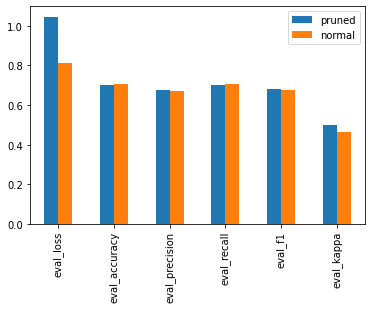

In [48]:
df_t.plot.bar()

@dataclass
class NoisyTrainingArguments(TrainingArguments):
    temperature: float = field(default=2.0, metadata={"help": "Temperature for the softmax temperature."})
    alpha_ce: float = field(default=0.5, metadata={"help":"Linear weight for the distillation loss. Must be >=0."})

class NoisyStudentTrainer(Trainer):
    def __init__(self, teacher_model, **kwargs):
        super().__init__(**kwargs)
        self.teacher_model = teacher_model
        
        # move the teacher model to the same device as the student model
        self._move_model_to_device(self.teacher_model, self.model.device)
    
    
    def compute_loss(self, model, inputs, return_outputs=False):
        # extract required parameters from our subclassed training arguments
        temperature = self.args.temperature
        alpha_ce = self.args.alpha_ce
        
        print(inputs)
        
        student_outputs = model(**inputs)
        with torch.no_grad():
            teacher_output = self.teacher_model(**inputs)
        t_logits = teacher_output.logits
        s_logits = student_outputs.logits
        
        attention_mask = inputs.get("attention_mask")
        
        # sanity check
        assert t_logits.size() == s_logits.size()
        
        # Kullback-Leibler Divergence loss (cross entropy)
        self.ce_loss_func = nn.KLDivLoss(reduction="batchmean")
        
        # compute KLDiv loss and multiply by alpha value
        loss_ce = self.ce_loss_func(nn.functional.log_softmax(s_logits / temperature, dim=-1),
                                    nn.functional.softmax(t_logits / temperature, dim=-1)) * (temperature ** 2)
        loss = alpha_ce * loss_ce
        
        return (loss, outputs) if return_outputs else loss

class NoisyRobertaConfig(RobertaConfig):
    def __init__(self, layerdrop=0.2, **kwargs):
        super().__init__(**kwargs)
        self.layerdrop = layerdrop

class NoisyRobertaEncoder(RobertaEncoder):
    # override the forward pass. Essentially mostly the same as the original code.
    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=False,
        output_hidden_states=False,
        return_dict=True,
    ):
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None
        all_cross_attentions = () if output_attentions and self.config.add_cross_attention else None

        next_decoder_cache = () if use_cache else None
        for i, layer_module in enumerate(self.layer):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            # add LayerDrop (see https://arxiv.org/abs/1909.11556 for description)
            dropout_probability = random.uniform(0, 1)
            if self.training and (dropout_probability < self.config.layerdrop):  # skip the layer
                layer_outputs = (None, None)
            else:
                layer_head_mask = head_mask[i] if head_mask is not None else None
                past_key_value = past_key_values[i] if past_key_values is not None else None

                if self.gradient_checkpointing and self.training:

                    if use_cache:
                        logger.warning(
                            "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                        )
                        use_cache = False

                    def create_custom_forward(module):
                        def custom_forward(*inputs):
                            return module(*inputs, past_key_value, output_attentions)

                        return custom_forward

                    layer_outputs = torch.utils.checkpoint.checkpoint(
                        create_custom_forward(layer_module),
                        hidden_states,
                        attention_mask,
                        layer_head_mask,
                        encoder_hidden_states,
                        encoder_attention_mask,
                    )
                else:
                    layer_outputs = layer_module(
                        hidden_states,
                        attention_mask,
                        layer_head_mask,
                        encoder_hidden_states,
                        encoder_attention_mask,
                        past_key_value,
                        output_attentions,
                    )

                hidden_states = layer_outputs[0]
                if use_cache:
                    next_decoder_cache += (layer_outputs[-1],)
                
            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)
                if self.config.add_cross_attention:
                    all_cross_attentions = all_cross_attentions + (layer_outputs[2],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    next_decoder_cache,
                    all_hidden_states,
                    all_self_attentions,
                    all_cross_attentions,
                ]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=next_decoder_cache,
            hidden_states=all_hidden_states,
            attentions=all_self_attentions,
            cross_attentions=all_cross_attentions,
        )

    
class NoisyRobertaForSequenceClassification(RobertaForSequenceClassification):
    def __init__(self, config: NoisyRobertaConfig):
        super().__init__(config)
        self.roberta.encoder = NoisyRobertaEncoder(config)
        self.roberta.post_init()

config = NoisyRobertaConfig(layerdrop=0, num_labels=num_labels, problem_type="multi_label_classification", max_length=512)
teacher_model = RobertaForSequenceClassification.from_pretrained(r"models_gitignored/roberta-base-finetuned-sentence-classification/checkpoint-75756/", num_labels=num_labels, problem_type="multi_label_classification").to(device)
model = NoisyRobertaForSequenceClassification(config).to(device)

model.roberta.embeddings.position_embeddings.weight.requires_grad = False
model.roberta.embeddings.token_type_embeddings.weight.requires_grad = False
#model

teacher_model.config

# REFERENCE LINKS: 
[HOW NICE A BLOG POST](https://www.philschmid.de/knowledge-distillation-bert-transformers) \
[HF FORUM POST DISTILLATION WITH TRAINER](https://discuss.huggingface.co/t/does-it-make-sense-to-train-distilbert-from-scratch-in-a-new-corpus/3503/2) \
[BART GITHUB SOURCE CODE CTRL+F LAYERDROP](https://github.com/huggingface/transformers/blob/v4.17.0/src/transformers/models/bart/modeling_bart.py) \
[ROBERTA GITHUB SOURCE CODE](https://github.com/huggingface/transformers/blob/v4.17.0/src/transformers/models/roberta/modeling_roberta.py) \
[DEVICE SIDE ASSERT TRIGGERED ERROR (TL;DR JUST RESTART KERNEL)](https://stackoverflow.com/questions/68166721/cuda-error-device-side-assert-triggered-on-colab)